## DA6401 Assignment 1
#### Achyutha M. - PH21B004

In [1]:
import wandb

from utils import wandb_helper
from utils import helper_functions
from utils import neural_network

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bullseye2608 (bullseye2608-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Question 1

In [3]:
# Load data
X_train, y_train, X_val, y_val, X_test, y_test = helper_functions.load_data('fashion_mnist')

# Log image examples to wandb
wandb_helper.log_images(X_train, y_train)


### Question 2

In [5]:
# Implemented and initialised the class NeuralNetwork
nn = neural_network.NeuralNetwork(
    layer_sizes=[784, 64, 64, 10],
    activation_functions=['relu', 'relu', 'softmax'],
    weight_decay=0.0,
    weight_init='xavier',
)

# Testing initialised model
y_init_pred = nn.forward_propagation(X_train)[0][-1]
init_accuracy = nn.compute_accuracy_from_predictions(y_init_pred, y_train)

print(f"Accuracy of Neural Network before training: {init_accuracy :<f}")

Accuracy of Neural Network before training: 0.096278


### Question 3

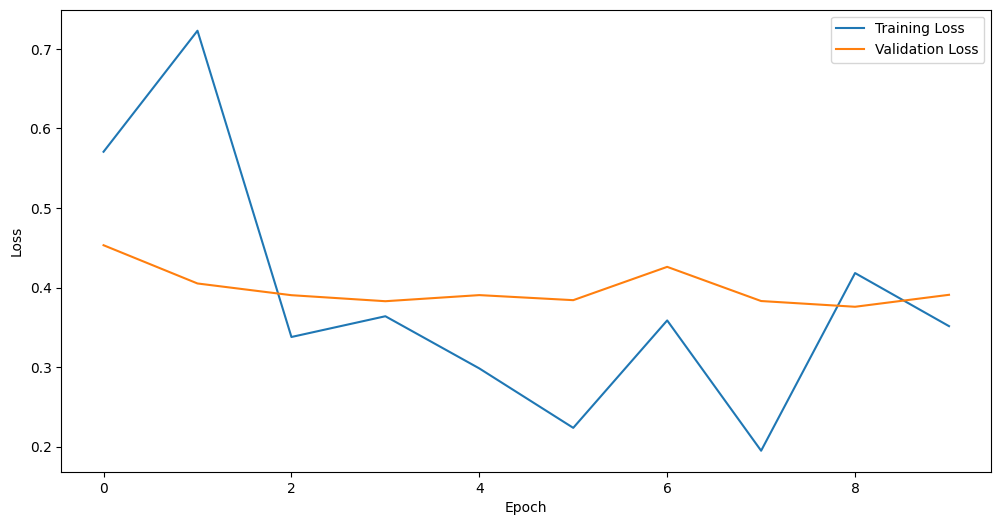

In [6]:
# Training the model
optimizer = {
    'name': 'adam',
    'learning_rate': 0.01,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8
}

nn.set_optimizer(optimizer_dict=optimizer)

history = nn.train(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    batch_size=64,
    num_epochs=10,
    loss_type='cross_entropy',
)

nn.plot_history(history)

In [7]:
nn.compute_accuracy(X_val, y_val)

np.float64(0.8616666666666667)

### Question 4

In [2]:
# Create New sweep
import yaml

with open("sweep_config.yaml", "r") as file:
        sweep_config = yaml.safe_load(file)

sweep_id = wandb.sweep(sweep_config, 
                       entity="bullseye2608-indian-institute-of-technology-madras",
                       project="fashion_mnist_hp_search")
trainer = wandb_helper.WandbTrainer()

# Run the sweep
wandb.agent(sweep_id, trainer.train, count=3)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: ko5b501d
Sweep URL: https://wandb.ai/bullseye2608-indian-institute-of-technology-madras/fashion_mnist_hp_search/sweeps/ko5b501d


wandb: Agent Starting Run: wqdyem1b with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
wandb: Currently logged in as: bullseye2608 (bullseye2608-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▁▁▁▁▁
train_loss,▁▇▅██
val_accuracy,▁▁▁▁▁
val_loss,▁████
epoch,4
test_accuracy,0.1
train_accuracy,0.10017
train_loss,2.30288
val_accuracy,0.0985


wandb: Agent Starting Run: wsrvkatr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	hidden_layers: 4
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
train_accuracy,███████████▇▄▂▁
train_loss,█▆▆▃▄▂▂▃▁▁▂▁▁▁▁
val_accuracy,███████████▆▄▁▁
val_loss,█▆▅▄▄▃▂▂▂▂▁▁▁▁▁
epoch,14
test_accuracy,0.0372
train_accuracy,0.03285
train_loss,2.31201
val_accuracy,0.035


wandb: Agent Starting Run: oxmfpm05 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▄▇▄▁█
train_loss,▃▁▇▅█
val_accuracy,▅▂▅█▁
val_loss,█▄▁▁▂
epoch,4
test_accuracy,0.1
train_accuracy,0.10026
train_loss,2.30595
val_accuracy,0.09767


### Question 7

In [3]:
import numpy as np
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

from utils.helper_functions import OptimalConfig

In [ ]:
# Run the optimal model configuration multiple times
def run_multiple_experiments(variation, log_aggregate_confusion_matrix=False):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # Define optimal hyperparameter configuration
    
    # Lists to store results from all runs
    all_metrics = []
    all_cms = []
    all_y_preds = []
    run_ids = []
    
    # Create a group ID for all runs
    group_id = f"optimal-config-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    # Set changes in runs
    
    num_runs = len(variation)
    
    # Run the model multiple times
    for run_id in range(num_runs):
        # Set a different random seed for each run
        np.random.seed(42 + run_id)
        config = OptimalConfig(**variation[run_id])
        
        # Initialize a new wandb run
        run = wandb.init(
            project="confusion_matrix_trials",
            name=f"optimal-run-{run_id+1}",
            tags=["optimal-config"],
            group=group_id,
            config=config,
        )
        # wandb.config.update(config)
        config.print_config()
        
        
        layer_sizes = [784] + [config.hidden_size]*config.num_layers + [10]
        activation_functions = [config.activation]*config.num_layers + ['softmax']
        
        nn = neural_network.NeuralNetwork(layer_sizes=layer_sizes, 
                        activation_functions=activation_functions,
                        weight_init=config.weight_init, 
                        weight_decay=config.weight_decay)
        
        wandb_callback = wandb_helper.WandbCallback()
        
        optimizer = helper_functions.get_optimizer(config.optimizer, config.learning_rate)
        nn.set_optimizer(optimizer)
        
        nn.train(
            X_train,
            y_train,
            X_val,
            y_val,
            batch_size=config.batch_size,
            num_epochs=config.epochs,
            loss_type=config.loss,
            log_every=1000,
            callback=wandb_callback
        )
        
        test_accuracy = nn.compute_accuracy(X_val, y_val)
        wandb.log({"test_accuracy": test_accuracy})
        
        # Evaluate the model
        test_loss = nn.compute_loss(nn.predict(X_val), y_val)
        test_acc = nn.compute_accuracy(X_val, y_val)
        
        # Get predictions
        y_pred_probs = nn.predict(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Store predictions
        all_y_preds.append(y_pred)
        
        # Create and log confusion matrix
        cm_file, cm, precision, recall, f1 = helper_functions.plot_confusion_matrix(y_val, y_pred, run_id)
        all_cms.append(cm)
        
        # Log confusion matrix image
        wandb.log({"confusion_matrix": wandb.Image(cm_file)})
        
        # Log interactive confusion matrix
        wandb.log({"confusion_matrix_plot": wandb.plot.confusion_matrix(
            probs=y_pred_probs,
            y_true=y_val,
            class_names=class_names
        )})
        
        # Log metrics
        run_metrics = {
            'test_loss': test_loss,
            'test_accuracy': test_acc,
            'run_id': run_id + 1
        }
    
        
        # Log all metrics
        wandb.log(run_metrics)
        
        # Store metrics for aggregate analysis
        all_metrics.append(run_metrics)
        run_ids.append(run.id)
        
        
        # Finish the run
        wandb.finish()
        
        print(f"Completed run {run_id+1}/{num_runs} with accuracy: {test_acc:.4f}")
    
    if log_aggregate_confusion_matrix:
        # Create an aggregate analysis run
        run = wandb.init(
            project="confusion_matrix_trials",
            name=f"aggregate-analysis-{num_runs}-runs",
            tags=["aggregate", "analysis", group_id],
            group=group_id
        )
        
        # Calculate average confusion matrix
        avg_cm = np.mean(all_cms, axis=0)
        std_cm = np.std(all_cms, axis=0)
        
        # Create and log aggregate confusion matrix
        plt.figure(figsize=(12, 10))
        avg_cm_normalized = avg_cm.astype('float') / avg_cm.sum(axis=1)[:, np.newaxis]
        
        fig = helper_functions.create_plotly_confusion_matrix(avg_cm, class_names, run_id=0)
        
        helper_functions.log_plotly_confusion_matrix_to_wandb(fig, run_id=0)
        
        
        avg_cm_df = pd.DataFrame(avg_cm_normalized, index=class_names, columns=class_names)
        
        sns.heatmap(avg_cm_df, annot=True, fmt='.2f', cmap='viridis', 
                    linewidths=.5, cbar_kws={"shrink": .8})
        
        # Calculate aggregate metrics
        accuracies = [m['test_accuracy'] for m in all_metrics]
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        
        plt.title(f'Aggregate Confusion Matrix (17 Runs)\nMean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}', fontsize=16)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # Save and log the aggregate confusion matrix
        agg_cm_file = "./confusion_matrices/"+"aggregate_confusion_matrix.png"
        plt.savefig(agg_cm_file, dpi=300, bbox_inches='tight')
        plt.close()
        
        wandb.log({"aggregate_confusion_matrix": wandb.Image(agg_cm_file)})
        
        # Log aggregate metrics
        agg_metrics = {
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'min_accuracy': min(accuracies),
            'max_accuracy': max(accuracies),
            'num_runs': num_runs
        }
        
        # Create a summary table with links to all runs
        run_table = wandb.Table(columns=["Run ID", "Accuracy"])
        for i, (run_id, metrics) in enumerate(zip(run_ids, all_metrics)):
            run_table.add_data(i+1, metrics['test_accuracy'])
        
        wandb.log({"runs_summary": run_table})
        wandb.log(agg_metrics)
        
        # Finish the aggregate run
        wandb.finish()
    
    return all_metrics, all_cms, all_y_preds

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

variation = [
        {},
        # {'loss': 'mean_squared_error'},
        {'batch_size': 32, 'num_layers': 4},
        {'epochs':15, 'batch_size': 128, 'num_layers': 5},
    ]

run_multiple_experiments(variation=variation, log_aggregate_confusion_matrix=True)
    
print("All runs completed!")

wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_init' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'hidden_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).


epochs: 10
batch_size: 64
loss: cross_entropy
optimizer: adam
learning_rate: 0.001
momentum: 0.9
beta: 0.9
beta1: 0.9
beta2: 0.999
epsilon: 1e-08
weight_decay: 0
weight_init: xavier
num_layers: 3
hidden_size: 128
activation: relu


NameError: name 'X_train' is not defined